# Data Retrieval and Database

## Speeding Up Data Retrieval

- We will go through the things we can do to speed data retrieval with Polars and Pandas.
- This will also provide an intuition for what database management systems automatically do during data retrival.

### Choose Columns When Loading Data
- Instead of loading all data: df = pd.read_csv(DATA_PATH)
- We can only load the data with the columns we will work with:

In [ ]:
import pandas as pd
DATA_PATH = "data_path"

# load data with selected columns using pandas
df = pd.read_csv(DATA_PATH, usecols=['column1', 'column2', 'column5'])

# we can also only load limited number of rows when exploring
df = pd.read_csv(DATA_PATH, nrows=10)

### Choose Right Data Type

Python has the following built-in data types:
- Text type: str
- Numeric types: int, float, complex
- Sequence types: list, tuple, range
- Mapping type: dict
- Set types: set, frozenset
- Boolean type: bool
- Binary types: bytes, bytearray, memoryview
- None type: NoneType

We care about data types since:
- Data types define what operations can be performed.
- Storing columns as certain data types can reduce memory requirements for loading a dataset

Below is an example of how we can set data type for columns of a pd dataframe when loading, to improve memory usage:

In [ ]:
dtype_dict = {'column1': 'int16', 'column2': 'int32'}
df = pd.read_csv('file.csv', dtype=dtype_dict)

# Comparision:

## Memory Size:
### np.int16: Uses 16 bits (2 bytes) to store an integer.
### np.int32: Uses 32 bits (4 bytes) to store an integer.

## Range of Values:
### np.int16: integers from -32,768 to 32,767.
### np.int32: integers from -2,147,483,648 to 2,147,483,647

## Use Cases:
### Use np.int16 when you need to save memory and your integers fall within the smaller range.

### Adjust Data Wrangling Order

Consider the below example, the original data wrangling pipeline:

In [ ]:
pd.read_csv('path').groupby('city').agg(n_adresses=('adress', 'nunique'),n_people=('name', 'size')).loc[lambda d: d['city'] == 'Amsterdam']
# first groug by city
# then compute aggregated measure
# find the aggregated measure corresponding to city Amsterdam

We can instead execute the imporved pipeline:

In [ ]:
pd.read_csv('path', usecols=['city', 'adress', 'name']).loc[lambda d: d['city'] == 'Amsterdam'].groupby('city').agg(n_adresses=('adress', 'nunique'), n_people=('name', 'size'))
# only load columns we use
# first filter the data to find observation with city name Amsterdam
# then group by city and compute aggrgetaed measure
# in this case, we only compute aggregated measures for Amsterdam, which save time and computation resources

The advantage of Polars over Pandas is that the Polars library can optimize the original data pipeline itself, without manual adjustment like we conducted for Pandas.

### Use Polars Library

Polars can outperform Pandas because it allows two types of evaluation (execution of code):
* **Eager Evaluation:**
    * Operations are executed immediately
    * Results are computed and stored in memory right away
    * e.g. pd.read_csv("example.csv") or pl.read_csv("example.csv")
* **Lazy Evaluation:**
    * Operations are deferred until explicitly executed
    * Query plan is built first, then optimised before execution
    * Better for large datasets and complex operations

Example of lazy evaluation in polars:

In [ ]:
lazy_frame = pl.scan_csv("example.csv").select("col_1") # create query
eager_frame = lazy_frame.collect() # polars inspect the query, optimize it, and then execute the query

How polars optimises the query:

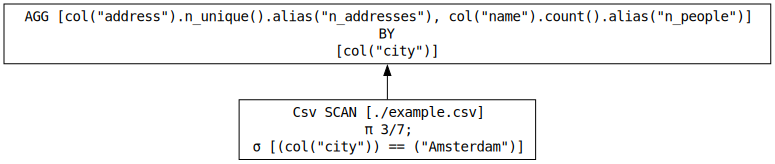

In [12]:
import polars as pl

query = (pl.scan_csv("./example.csv")
         .group_by("city")
         .agg(n_addresses=pl.col("address").n_unique(), n_people=pl.col("name").count())
         .filter(pl.col("city") == "Amsterdam"))

query.show_graph()

We define the data pipeline to be the same as the unimproved pd pipeline.
However, before execuation, the polars library optimize the query plan (optimised plan should be read from bottom to top):
1. Filter the obs with city == "Amsterdam" (σ stands for filtering and indicates any filter conditions)
2. Only load the columns that will be used (π for projection and indicates choosing a subset of column, in our case, 3 out of 7)
3. COnduct group by and aggregation

Formal illustration:
1. The first step optimisation is called Predicate Pushdown; which means ”pushing down” filtering conditions as close as possible to the data source before processing the rest of the query.
2. The second step optimisation is called Projection Pushdown; which means select columans that need to be read by applying a linear algebra projection matrix projecting onto the matrix representation of the dataframe.

Additional note: query optimiser of polars applies filter while the CSV is read from disk rather than reading the entire file into memory and then applying the filter.
This further reduce memory requirement.

### Loading Data in Chunks

- With Polars, we can do lazy evaluation, but at some point we still need to load the result into memory (RAM).
- If the data size is larger than the memory, we have to load and operate on it in chunks.

In pandas:

In [14]:
# Initialize list to store processed chunks
processed_chunks = []

# Read and process data in chunks
chunk_size = 1000
for chunk in pd.read_csv('example.csv', chunksize = chunk_size):
    # Process chunk by dividing values by 2
    chunk['id'] = chunk['id'] / 2
    # Store processed chunk
    processed_chunks.append(chunk)

# Combine all processed chunks into final result
final_result = pd.concat(processed_chunks, ignore_index=True)
final_result

,Unnamed: 0,id,name,city,address,order_id,time
0,0,0.5,Name_1,Rome,Address_1,161629,2024-01-01 00:00:00
1,1,1.0,Name_2,London,Address_2,428184,2024-01-01 01:00:00
2,2,1.5,Name_3,Paris,Address_3,592734,2024-01-01 02:00:00
3,3,2.0,Name_4,Madrid,Address_4,855195,2024-01-01 03:00:00
4,4,2.5,Name_5,Amsterdam,Address_5,390160,2024-01-01 04:00:00
...,...,...,...,...,...,...,...
295,295,148.0,Name_296,London,Address_296,730265,2024-01-13 07:00:00
296,296,148.5,Name_297,Rome,Address_297,713157,2024-01-13 08:00:00
297,297,149.0,Name_298,Paris,Address_298,729474,2024-01-13 09:00:00
298,298,149.5,Name_299,Madrid,Address_299,921106,2024-01-13 10:00:00


In Polars:

In [17]:
# Read and process data using Polars streaming
result = (pl.scan_csv('example.csv')
          .with_columns(pl.col('id') / 2)
          .collect(streaming=True)) # Use streaming in collect to process in chunks
result

/var/folders/qb/pd0pzd3x0jj2c_2nkn2hmrxw0000gn/T/ipykernel_19880/794258352.py:4: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)) # Use streaming in collect to process in chunks


,id,name,city,address,order_id,time
i64,f64,str,str,str,i64,str
0,0.5,"""Name_1""","""Rome""","""Address_1""",161629,"""2024-01-01 00:00:00"""
1,1.0,"""Name_2""","""London""","""Address_2""",428184,"""2024-01-01 01:00:00"""
2,1.5,"""Name_3""","""Paris""","""Address_3""",592734,"""2024-01-01 02:00:00"""
3,2.0,"""Name_4""","""Madrid""","""Address_4""",855195,"""2024-01-01 03:00:00"""
4,2.5,"""Name_5""","""Amsterdam""","""Address_5""",390160,"""2024-01-01 04:00:00"""
…,…,…,…,…,…,…
295,148.0,"""Name_296""","""London""","""Address_296""",730265,"""2024-01-13 07:00:00"""
296,148.5,"""Name_297""","""Rome""","""Address_297""",713157,"""2024-01-13 08:00:00"""
297,149.0,"""Name_298""","""Paris""","""Address_298""",729474,"""2024-01-13 09:00:00"""


In Polars, the size of the batch/chunk is automatically determined by:
- The number of CPUs on your machine
- The amount of memory each row in your query requires

If the data wrangling result does not fit into memory either, we can write the output directly to a file on disk using the sink_methods (this is actually very useful, and something that only database frameworks but not data wrangling frameworks could do): 

In [ ]:
query.sink_parquet("example.parquet")

## Database Management Systems

- A big advantage of database management system is that it automatically conducts above data retrieval optimization, including chunking, predicate and projection pushdowns.
- Beyond that, relational databases contain more information on the data, such as relationships among tables and indexes, to speed up the data retrieval and make storage more secure.
- We communicated with a database using a programming language called SQL (structured query language).

### Relational Database

- A relational database is a type of database that stores and organises data in tables with predefined **relationships** between them based on **keys**.
- Each table in the relational database have a **primary key**, which uniquely identifies every row in the table.
- Some of the table also has **foreign key**, which refers to the primary key of another table.
- Tables are connected through primary–foreign key relationships.

Consider an example of a database for an e-commerce platform with two tables:
- Customer table: the primary key is customer_id, other columns store customer information.
- Order table: the primary key is order_id, the foreign key is customer_id, representing the customer and make the order; the other columns store other order information.
- The two tables can be connected through customer_id: customer_id is primary key in customer table, and it is foreign key in order table.
- The relationship between these two tables is 1:n, since one customer can make several orders (1 customer_id can be mapped to N order_id since there are duplicated customer_id in the order table).

![my plot](graphs/relation_database.png)

### Structured Query Language

- SQL is a programming language to store and work with data in a relation database.
- When receiving a SQL query, the query processor of the database management system creates a plan for retrieving or writing data in the most effective way.


SQL syntax:
* SQL is not case sensitive, but it is best practice to write the commands in uppercase.
* SQL queries have to be written in a specific order: SELECT ... FROM ... WHERE ... GROUP BY ... HAVIN ... ORDER BY ... LIMIT ...
    * SELECT ... FROM ... retrieve specified columns from a deisgnated table
    * WHERE filters individual rows (before they’re grouped, if there is a GROUP BY followed)
    * GROUP BY groups data based on unique combination of one/more columns for computing aggregated measures (aggregation operation: count(*), max(col_name), min(col_name), avg(col_name),...)
    * HAVING filters groups after the GROUP BY
    * ORDER BY ... sort the result based on some column
    * LIMIT ... limit the result for first n rows
* Equality is written with ”col_1=2” and not ”col_1 == 2”
* To check whether a column has NULL entries, write ”col_1 IS NULL” rather than ”col_1 = NULL"
* Limit queries to test code: SELECT * FROM my_table LIMIT 10

### How Database Optimize Data Retrieval
1. Automatically optimize query plan: adjust order of operation, conduct chunking, predicate and projection pushdowns
2. Construct a tree structure of indexes to make data retrieval quicker

Three structure of indexes:
* We can specify which columns are indexes when creating a table using database management system.
* The database engine will automatically build a tree structure for the indexed column, optimize tree depth and values to split to speed up data retrival.
* Suppose "name" is an index of the table; conceptually, we can think of the index as grouping values alphabetically. 
    * For example, the upper levels of the tree might divide names into ranges such as A–C, D–F, G–I, and so on. 
    * Lower levels further narrow these ranges (Da–Df, Dg–Dl, etc.); the actual structure is optimized by the database engine.
* When we exectue the query: SELECT * FROM table_name WHERE name = ’Darcy’, the database will not scan all rows to find the row with name = mr darcy. Instead, it follows the tree:
    * It selects the branch containing the range that includes “D”.
    * It moves to the next layer where the range is further narrowed, such as Da–De.
    * It continues descending until it reaches the leaf node containing “Darcy”.
* As a result, the number of operations is proportional to the height of the B-tree, typically only 3–6 steps (log(N)) even for millions of rows, instead of scanning N rows.

### Python and Database

How to load SQL query result to a pd dataframe:

In [ ]:
import sqlite3 as sql
con = sql.connect("example_database/nba.sqlite") #connect to the database
df_games = pd.read_sql("SELECT * FROM game LIMIT 10", con) #execute sql query, save to pd dataframe
df_games

,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type
0,21946,1610610035,HUS,Toronto Huskies,0024600001,1946-11-01 00:00:00,HUS vs. NYK,L,0,25.0,...,None,None,None,None,None,NaN,68.0,2,0,Regular Season
1,21946,1610610034,BOM,St. Louis Bombers,0024600003,1946-11-02 00:00:00,BOM vs. PIT,W,0,20.0,...,None,None,None,None,None,25.0,51.0,-5,0,Regular Season
2,21946,1610610032,PRO,Providence Steamrollers,0024600002,1946-11-02 00:00:00,PRO vs. BOS,W,0,21.0,...,None,None,None,None,None,NaN,53.0,-6,0,Regular Season
3,21946,1610610025,CHS,Chicago Stags,0024600004,1946-11-02 00:00:00,CHS vs. NYK,W,0,21.0,...,None,None,None,None,None,22.0,47.0,-16,0,Regular Season
4,21946,1610610028,DEF,Detroit Falcons,0024600005,1946-11-02 00:00:00,DEF vs. WAS,L,0,10.0,...,None,None,None,None,None,NaN,50.0,17,0,Regular Season
5,21946,1610610026,CLR,Cleveland Rebels,0024600006,1946-11-03 00:00:00,CLR vs. HUS,W,0,24.0,...,None,None,None,None,None,NaN,60.0,-11,0,Regular Season
6,21946,1610610031,PIT,Pittsburgh Ironmen,0024600007,1946-11-04 00:00:00,PIT vs. WAS,L,0,19.0,...,None,None,None,None,None,NaN,71.0,15,0,Regular Season
7,21946,1610612738,BOS,Boston Celtics,0024600008,1946-11-05 00:00:00,BOS vs. CHS,L,0,23.0,...,None,None,None,None,None,NaN,57.0,2,0,Regular Season
8,21946,1610610028,DEF,Detroit Falcons,0024600009,1946-11-05 00:00:00,DEF vs. BOM,L,0,18.0,...,None,None,None,None,None,NaN,53.0,4,0,Regular Season
9,21946,1610610032,PRO,Providence Steamrollers,0024600011,1946-11-07 00:00:00,PRO vs. CHS,W,0,31.0,...,None,None,None,None,None,14.0,65.0,-8,0,Regular Season


For complex SQL query, we may want to create temporary tables to simplify the data wrangling pipeline:
- we can create a temporary table on disk with SQL (not with pandas)
- temporary tables are only stored during the sqlite session
- we can also create a ”View” which is stored even when we close the session

In [19]:
# what were the top 10 games with the most plays?
import sqlite3 as sql
con = sql.connect("example_database/nba.sqlite")

query = """
CREATE TEMPORARY TABLE plays_per_game AS
    SELECT game_id, COUNT(*) AS number_of_plays
    FROM play_by_play
    GROUP BY game_id
"""
con.execute(query)

query = """
SELECT *
FROM game AS g
LEFT JOIN plays_per_game AS ppg
    ON g.game_id = ppg.game_id
WHERE season_type = 'Playoffs'
ORDER BY ppg.number_of_plays DESC
LIMIT 10
"""

pd.read_sql(query, con)

,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,...,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type,game_id,number_of_plays
0,42003,1610612765,DET,Detroit Pistons,0040300215,2004-05-14 00:00:00,DET vs. NJN,L,315,42.0,...,8.0,9.0,34.0,42.0,127.0,7,0,Playoffs,0040300215,673
1,42010,1610612763,MEM,Memphis Grizzlies,0041000224,2011-05-09 00:00:00,MEM vs. OKC,L,315,40.0,...,9.0,8.0,18.0,31.0,133.0,10,0,Playoffs,0041000224,653
2,42018,1610612757,POR,Portland Trail Blazers,0041800233,2019-05-03 00:00:00,POR vs. DEN,W,340,52.0,...,11.0,8.0,21.0,27.0,137.0,-3,1,Playoffs,0041800233,634
3,42012,1610612741,CHI,Chicago Bulls,0041200134,2013-04-27 00:00:00,CHI vs. BKN,W,315,58.0,...,7.0,10.0,20.0,27.0,134.0,-8,1,Playoffs,0041200134,623
4,42013,1610612745,HOU,Houston Rockets,0041300171,2014-04-20 00:00:00,HOU vs. POR,L,265,43.0,...,7.0,6.0,12.0,32.0,122.0,2,1,Playoffs,0041300171,618
5,42008,1610612741,CHI,Chicago Bulls,0040800116,2009-04-30 00:00:00,CHI vs. BOS,W,315,49.0,...,6.0,6.0,13.0,29.0,127.0,-1,0,Playoffs,0040800116,606
6,42018,1610612761,TOR,Toronto Raptors,0041800303,2019-05-19 00:00:00,TOR vs. MIL,W,290,40.0,...,14.0,5.0,20.0,30.0,112.0,-6,1,Playoffs,0041800303,606
7,42008,1610612741,CHI,Chicago Bulls,0040800114,2009-04-26 00:00:00,CHI vs. BOS,W,290,45.0,...,10.0,4.0,21.0,31.0,118.0,-3,0,Playoffs,0040800114,596
8,42004,1610612751,NJN,New Jersey Nets,0040400103,2005-04-28 00:00:00,NJN vs. MIA,L,290,42.0,...,9.0,3.0,18.0,25.0,108.0,3,0,Playoffs,0040400103,593
9,42006,1610612765,DET,Detroit Pistons,0040600305,2007-05-31 00:00:00,DET vs. CLE,L,290,34.0,...,8.0,5.0,14.0,36.0,109.0,2,0,Playoffs,0040600305,583


Write Pandas data frames to the DB:

In [ ]:
import sqlite3 as sql
con = sql.connect("nba.sqlite")
df_games.to_sql("top_10", con) #"top_10" is the new table name in the database

Create new table (empty) with sqlite3:

In [ ]:
con = sql.connect("nba.sqlite") #the nba.sqlite file store the complete database, the csv folder is only used to illustarte what tables are presented in the database (not updated)
con.execute("CREATE TABLE salaries(player_id, year, salary)")

Build a new database with sqlite3:

In [ ]:
con_new = sql.connect("new.sqlite")
con_new.execute("CREATE TABLE movie(title, score)")

Close connection to sqlite3 database:

In [23]:
con.close()

**DuckDB:**
- An alternative database system that allows us to create database and write query using Python
- The DuckDB can query parquet and csv using SQL directly
- It adopts hive partitioning strategy; if detected data files are in a hive partitioned hierarchy, filters on the partition keys are automatically pushed down
- This way the system skips reading files that are not necessary to answer a query

Read parquet using DuckDB:
- Suppose that the order table is stored as parquet files in the order folder, with folder structure above.
- Within each folder, the partition key has a value that is determined by the name of the folder.
- DuckDB can automatically detect these partion keys, it will create two additional columns for partion keys "year" and "month", when reading the parquet files.
- When filtering on the partion keys in the SQL query, e.g. filter on "year = 2022 AND month = 5", the DuckDB only read parquet files in the path orders/year 2022/month 5 (as these files are the only necessary ones to answer the query)

In [ ]:
# example of reading parquet using DuckDB and filtering on partion keys
import duckdb as ddb

query = """
    SELECT * 
    FROM read_parquet('orders/*/*/*.parquet')
    WHERE year = 2022 
        AND month = 5
"""
con = ddb.connect()
con.sql(query).show()

DuckDB can also create a database from parquet file:

In [ ]:
con = ddb.connect("new_database.ddb")

query = """
    CREATE TABLE nyc_taxi 
    AS
        SELECT * 
        FROM read_parquet('orders/*/*/*.parquet')
        WHERE year = 2022 
            AND month = 5
"""

con.sql(query)

## Data Storage and Management Landscape

Data management concepts:
1. Database management system: store structured data in a relational database (tables linked through primary keys and foriegn keys), include an engine to interpret and execute SQL query, optimize query plans for both data retrieval and writting.
2. Data warehouse: store structured data generated through scheduled ETL (extract, transform, load) processes that are implmented on database (source of data), often adopt a distributed file system (data files save on different machines), and optimize for analytical queries (such as aggregation) not for frequent write/update operation
3. Data lake: store both structed and unstructured data in files, often adopt distributed file system, optimize for cheap and flexible large scale storage

## Extra on Python Development Tools

### .gitignore
Tell Git to ignore certain files in the repo:
- Large data files
- API keys
- Graphs (.png)

### Type Hints

A method to specify what should go in and what should come out for a function (specify input data type and output data type):

In [ ]:
def multi_two_numbers(a: int, b: int) -> int:
    return a * b

Type hints with default arguments:

In [ ]:
def greet(name: str = "World") -> str:
    return f"Hello, {name}!"

Some data types for function input are not available natively, but we can easily extend types by using typing package:

In [ ]:
from typing import List
def some_funct(a: List[int]) -> List[str]:
    return [str(x) for x in a]

Cheatsheet for built in types: https://mypy.readthedocs.io/en/stable/cheat_sheet_py3.html

Note: 
- Python’s type hints don’t enforce types by themselves
- But, they’re valuable for documentation
- And we can use hook in pre-commit to conduct type checking

### pre-commit
- Pre-commit is a Python package; it runs every listed hook (represent a script) in the .pre-commit-config.yaml file to conduct some checking
- Common checks include: if our code follows certain standards (line length of 80 or no trailing white space), and if type hints present in functions

Install pre-commit:
1. pip install pre-commit #install package
2. pre-commit sample-config > .pre-commit-config.yaml #generate a template of config file, we need to add hook into this file
3. pre-commit install #install all hooks we listed in the config file

Example of a .pre-commit-config.yaml file:

In [ ]:
# See https://pre-commit.com for more information
# See https://pre-commit.com/hooks.html for more hooks
repos:
  - repo: https://github.com/pre-commit/pre-commit-hooks #github repo of pre-commit package
    rev: v3.2.0
    hooks: #these hooks are necessary
      - id: trailing-whitespace
      - id: end-of-file-fixer
      - id: check-yaml
      - id: check-added-large-files
  - repo: https://github.com/PyCQA/flake8 # url to the github repo for aditional hook that we want to install, e.g. flake8
    rev: 7.1.1 # release tag of the version we want to install
    hooks:
      - id: flake8 # name of the hook we want to install (repo, rev, id are necessary for all hooks we want to install)
  - repo: https://github.com/pre-commit/mirrors-mypy # if type hints are provided, mypy checks whether the input of functiosn have correct types
    rev: v1.13.0
    hooks:
      - id: mypy
        additional_dependencies: [types-seaborn, polars, pandas-stubs, matplotlib]
        args: ["--ignore-missing-imports", "--strict"]
  - repo: https://github.com/kynan/nbstripout #this hook strip out juypter notebook output
    rev: 0.7.1
    hooks:
      - id: nbstripout
  - repo: https://github.com/psf/black #this hook conduct automatic formating for our script
    rev: 23.12.1
    hooks:
      - id: black
        args: [--line-length=79] # Match flake8's default line length


Pre-commit will run all hooks every time we want to commit:
- When they find an error we will have to ”git add” them and then run the commit again
- Or if the error is not automatically fixed, we have to first fix it, ”git add”, and then ”git commit” again

Common hooks:
- **Flake8:** It is a code linter to check our code for Line length and unused imports
- **Black:** It is a code formatter that automatically reformats our code

Other hooks:  https://pre-commit.com/hooks.html

When we change configuration for pre-commit, we need to clean the cache:

In [ ]:
pre-commit clean && pre-commit install

To update hooks:

In [ ]:
pre-commit autoupdate